First we need to import the useful libraries and load the data that we have previously prepared.

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pickle

Using TensorFlow backend.


In [2]:
print('\nFINAL PREDICTIONS OVER THE TRAINING SET')
#Load data and labels
print('\nLoading data...\n')

project_dir='path\to\data'
file_name_h5 = os.path.join(project_dir, 'farmboys_data.h5')
h5f = h5py.File(file_name_h5,'r')
X = h5f['dataset'][:]
h5f.close()

y_list=[]
file_name_txt = os.path.join(project_dir, 'farmboys_labels.txt')
file = open(file_name_txt,"r") 
for line in file:
    y_list.append(line.strip())
y=np.asarray(y_list).astype(np.float64)

print('Samples loaded successfully:',X.shape)
print('Labels loaded successfully:',y.shape)


FINAL PREDICTIONS OVER THE TRAINING SET

Loading data...

Samples loaded successfully: (200, 18)
Labels loaded successfully: (200,)


Since we need to predict the yield from the previously trained models, we have to load them first.

In [4]:
print('\nLoading trained models...\n')

#RF
model_file=os.path.join(project_dir,'model_rf.sav')
model_rf = pickle.load(open(model_file, 'rb'))
print('\nLoaded RF model summary:\n',model_rf)

#SVR
model_file=os.path.join(project_dir,'model_svr.sav')
model_svr = pickle.load(open(model_file, 'rb'))
print('\nLoaded SVR model summary:\n',model_svr)

#NN
model_file=os.path.join(project_dir,'model_nn.h5')
model_nn=load_model(model_file)
print('\nLoaded DNN model summary:\n')
model_nn.summary()


Loading trained models...


Loaded RF model summary:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Loaded SVR model summary:
 SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Loaded DNN model summary:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 48)                912       
_________________________________________________________________
dense_18 (Dense)    

We are going to use this model to generate predictions over the completa dataset, given the small amount of data. However, these predictions are going to be split and analyzed per crop.

In [5]:
#Feature scaling and separation by crop
stdsc=StandardScaler()
X_scl=stdsc.fit_transform(X)

train_crops=['Garlic Chives H', 'Basil H', 'Red Chard TL',
      'Rainbow Chard TL', 'Arugula TL', 'Mint H']

print(' Crops that will be used: ',train_crops)

 Crops that will be used:  ['Garlic Chives H', 'Basil H', 'Red Chard TL', 'Rainbow Chard TL', 'Arugula TL', 'Mint H']


In [6]:
#Plot regression
def plot_regression(title,y_pred,y_true,r2):
    plt.figure(figsize=(5,4))
    plt.scatter(y_pred,y_true,c='green')
    plt.xlabel('Predicted values (yield)')
    plt.ylabel('Real values (yield)')
    plt.text(min(y_pred),max(y_pred),
             title+' R2_score = '+str(round(np.mean(r2),3)),color='red')
    plt.show()

We now generate the predictions and plot the results. It is important to note that here we have calculated the optimum weights that maximize the coefficient of determination for this ensemble of models. The final ensemble uses the RF and DNN models.

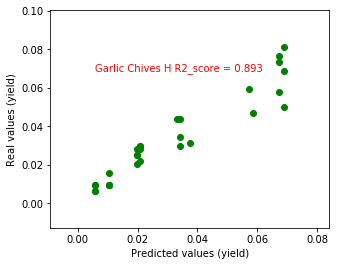

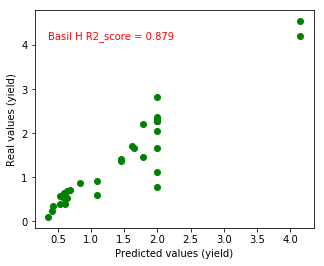

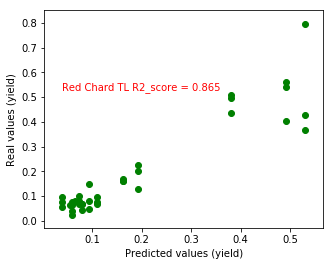

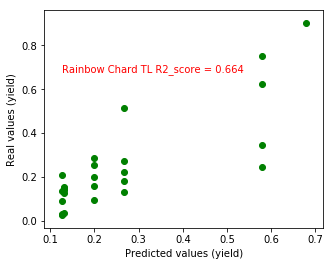

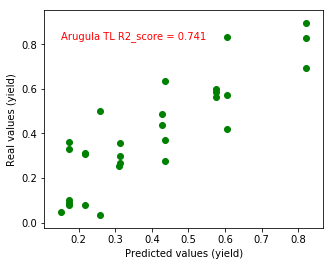

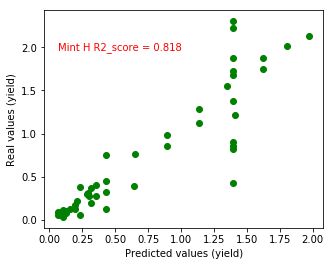

In [7]:
r2_crops=[]
for num_crop,crop in enumerate(train_crops):
    X_crop=[]
    X_scl_crop=[]
    y_crop=[]
    for i in range(len(X)):
        if X[i,num_crop]!=0:
            X_crop.append(X[i,:])
            X_scl_crop.append(X_scl[i,:])
            y_crop.append(y[i])
    X_crop=np.asarray(X_crop)
    X_scl_crop=np.asarray(X_scl_crop)
    y_crop=np.asarray(y_crop)
    
    #Ensemble
    y_pred_rf=model_rf.predict(X_crop)
    y_pred_svr=model_svr.predict(X_scl_crop)
    y_pred_nn=model_nn.predict(X_scl_crop)[:,0]
    y_pred=0.52*y_pred_rf+0.48*y_pred_nn
    
    r2=r2_score(y_crop,y_pred)
    r2_crops.append(r2)
    plot_regression(crop,y_pred,y_crop,r2)
    
avr_r2=np.mean(r2_crops)
r2_crops.append(avr_r2)
train_crops.append('average')

Finally, we save the results. With the ensemble of models we have improved the generalization capacity and we obtained a more uniform coefficient of determination among the different crops. You can read more about this in the paper.

In [9]:
result_df=pd.DataFrame(r2_crops,index=[train_crops])
print(result_df)
file_summary=project_dir+'/r2_results.csv'
result_df.to_csv(file_summary,header=False)

print('Results saved correctly!')
print("\nJob finished! =) \n")

                         0
Garlic Chives H   0.892838
Basil H           0.878924
Red Chard TL      0.865027
Rainbow Chard TL  0.664179
Arugula TL        0.740715
Mint H            0.818443
average           0.810021
Results saved correctly!

Job finished! =) 

